# March Madness Rating Computation

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from data_format.rating_systems.stephenson import *
from data_format.rating_systems.glicko2 import *
from data_format.rating_systems.elo_v2 import *
import copy
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, brier_score_loss, mean_absolute_error, log_loss
from sklearn.preprocessing import StandardScaler
from scipy.interpolate import UnivariateSpline # interpolate win margin model to probabilities

In [2]:
DATA_PATH = 'data/'

gender = 'm'

if gender == 'm':
    adj_path = "mens/M"
    day_cutoff = 136
else:
    adj_path = "womens/W"
    day_cutoff = 137

tourney_results = pd.concat([
    pd.read_csv(DATA_PATH + adj_path + "NCAATourneyDetailedResults.csv"),
], ignore_index=True)

second_tourney_results = pd.concat([
    pd.read_csv(DATA_PATH + adj_path + "SecondaryTourneyCompactResults.csv"),
], ignore_index=True)

seeds = pd.concat([
    pd.read_csv(DATA_PATH + adj_path + "NCAATourneySeeds.csv"),
], ignore_index=True)

regular_results = pd.concat([
    pd.read_csv(DATA_PATH + adj_path + "RegularSeasonDetailedResults.csv"),
], ignore_index=True)

potential_matchups = pd.concat([
    pd.read_csv(DATA_PATH + "mens/MNCAATourneySeedRoundSlots.csv"),
], ignore_index=True)

In [3]:
def prepare_data(df):
    # Possessions = FGA-OR+TO+.475*FTA
    W_poss = df['WFGA'] - df['WOR'] + df['WTO'] + .475 * df['WFTA']
    L_poss = df['LFGA'] - df['LOR'] + df['LTO'] + .475 * df['LFTA']
    
    df['WOER'] = df['WScore'] / W_poss
    df['LOER'] = df['LScore'] / L_poss
    
    # Normalize OER values
    df['WOER'] = (df['WOER'] - .7)/.6
    df['LOER'] = (df['LOER'] - .7)/.6
    
    dfswap = df[['Season', 'DayNum', 'LTeamID', 'LScore', 'WTeamID', 'WScore', 'WLoc', 'NumOT',
                'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst',
                'LTO', 'LStl', 'LBlk', 'LPF', 'LOER',
                'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst',
                'WTO', 'WStl', 'WBlk', 'WPF', 'WOER']]
    
    dfswap.loc[df['WLoc'] == 'H', 'WLoc'] = 'A'
    dfswap.loc[df['WLoc'] == 'A', 'WLoc'] = 'H'
    
    df.columns.values[6] = 'location'
    dfswap.columns.values[6] = 'location'
    
    df.columns = [x.replace('W','T1_').replace('L','T2_') for x in list(df.columns)]
    
    dfswap.columns = [x.replace('L','T1_').replace('W','T2_') for x in list(dfswap.columns)]
    
    output = pd.concat([df, dfswap]).reset_index(drop=True)
    
    output.loc[output.location=='N','location'] = '0'
    output.loc[output.location=='H','location'] = '1'
    output.loc[output.location=='A','location'] = '-1'
    output.location = output.location.astype(int)
    
    output['PointDiff'] = output['T1_Score'] - output['T2_Score']
    output['win'] = np.where(output['T1_Score']>output['T2_Score'], 1, 0)
    
    output['T1_TeamID'] = output['T1_TeamID'].astype(int)
    output['T2_TeamID'] = output['T2_TeamID'].astype(int)
    
    return output

In [4]:
tourney_data = prepare_data(tourney_results)
regular_data = prepare_data(regular_results)

second_tourney_results_swap = second_tourney_results[['Season', 'DayNum', 'LTeamID', 'LScore', 'WTeamID', 'WScore', 'NumOT']]

second_tourney_results.columns = [x.replace('W','T1_').replace('L','T2_') for x in list(second_tourney_results.columns)]
second_tourney_results_swap.columns = [x.replace('L','T1_').replace('W','T2_') for x in list(second_tourney_results_swap.columns)]

second_tourney_results = pd.concat([second_tourney_results, second_tourney_results_swap]).reset_index(drop=True)

second_tourney_results['PointDiff'] = second_tourney_results['T1_Score'] - second_tourney_results['T2_Score']
second_tourney_results['win'] = np.where(second_tourney_results['T1_Score']>second_tourney_results['T2_Score'], 1, 0)

second_tourney_results['T1_TeamID'] = second_tourney_results['T1_TeamID'].astype(int)
second_tourney_results['T2_TeamID'] = second_tourney_results['T2_TeamID'].astype(int)

In [5]:
# not interested in pre-selection matches - first four started 2011 mens 2022 women
# 136 FOR MENS 137 FOR WOMEN
tourney_data = tourney_data.loc[tourney_data['DayNum'] >= day_cutoff].reset_index(drop=True)

# #Add round
def assign_intervals(day_nums):
    day_to_interval = {}
    days = sorted(set(day_nums)) #unique + sorted

    interval_mapping = {
        (0, 1): 1, # First round
        (2, 3): 2, # Second round
        (4, 5): 3, # Sweet sixteen
        (6, 7): 4, # Elite eight
        (8, 8): 5, # Final four
        (9, 9): 6, # Finals
    }

    for i, day in enumerate(days):
        for (start, end), interval in interval_mapping.items():
            if start <= i <= end:
                day_to_interval[day] = interval
                break

    return day_nums.map(day_to_interval)  # Map backto index

# Apply function to each Season group
tourney_data['round'] = tourney_data.groupby("Season")['DayNum'].transform(assign_intervals)
# tourney_data = tourney_data.drop(columns=['DayNum'])

In [6]:
boxscore_cols = [
        'T1_FGM', 'T1_FGA', 'T1_FGM3', 'T1_FGA3', 'T1_OR', 'T1_Ast', 'T1_TO', 'T1_Stl', 'T1_Blk', 'T1_PF', 'T1_OER',
        'T2_FGM', 'T2_FGA', 'T2_FGM3', 'T2_FGA3', 'T2_OR', 'T2_Ast', 'T2_TO', 'T2_Stl', 'T2_Blk', 'T2_PF', 'T2_OER',
        'PointDiff']

In [7]:

season_statistics = regular_data.groupby(["Season", 'T1_TeamID'])[boxscore_cols].agg("mean")
season_statistics = regular_data.groupby(["Season", 'T1_TeamID'])[boxscore_cols].agg("mean").reset_index()
season_statistics.columns = [''.join(col).strip() for col in season_statistics.columns.values]

In [8]:
season_statistics_T1 = season_statistics.copy()
season_statistics_T2 = season_statistics.copy()

season_statistics_T1.columns = ["T1_" + x.replace("T1_","").replace("T2_","opponent_") for x in list(season_statistics_T1.columns)]
season_statistics_T2.columns = ["T2_" + x.replace("T1_","").replace("T2_","opponent_") for x in list(season_statistics_T2.columns)]
season_statistics_T1.columns.values[0] = "Season"
season_statistics_T2.columns.values[0] = "Season"

In [9]:
tourney_data = tourney_data[['Season', 'round', 'DayNum', 'T1_TeamID', 'T1_Score', 'T2_TeamID' ,'T2_Score', 'win']]
tourney_data = pd.merge(tourney_data, season_statistics_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, season_statistics_T2, on = ['Season', 'T2_TeamID'], how = 'left')

In [10]:
last14days_stats_T1 = regular_data.loc[regular_data.DayNum>118].reset_index(drop=True)
last14days_stats_T1['win'] = np.where(last14days_stats_T1['PointDiff']>0,1,0)
last14days_stats_T1 = last14days_stats_T1.groupby(['Season','T1_TeamID'])['win'].mean().reset_index(name='T1_win_ratio_14d')

last14days_stats_T2 = regular_data.loc[regular_data.DayNum>118].reset_index(drop=True)
last14days_stats_T2['win'] = np.where(last14days_stats_T2['PointDiff']<0,1,0)
last14days_stats_T2 = last14days_stats_T2.groupby(['Season','T2_TeamID'])['win'].mean().reset_index(name='T2_win_ratio_14d')

In [11]:
tourney_data = pd.merge(tourney_data, last14days_stats_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, last14days_stats_T2, on = ['Season', 'T2_TeamID'], how = 'left')

In [12]:
regular_season_effects = regular_data[['Season','T1_TeamID','T2_TeamID','PointDiff']].copy()
regular_season_effects['T1_TeamID'] = regular_season_effects['T1_TeamID'].astype(str)
regular_season_effects['T2_TeamID'] = regular_season_effects['T2_TeamID'].astype(str)
regular_season_effects['win'] = np.where(regular_season_effects['PointDiff']>0,1,0)
march_madness = pd.merge(seeds[['Season','TeamID']],seeds[['Season','TeamID']],on='Season')
march_madness.columns = ['Season', 'T1_TeamID', 'T2_TeamID']
march_madness.T1_TeamID = march_madness.T1_TeamID.astype(str)
march_madness.T2_TeamID = march_madness.T2_TeamID.astype(str)
regular_season_effects = pd.merge(regular_season_effects, march_madness, on = ['Season','T1_TeamID','T2_TeamID'])
regular_season_effects.shape

(13024, 5)

In [13]:
def update_team_rating_s(df_team, row, rating_type='rating'):
    team_one = df_team.loc[df_team['TeamID'] == row['T1_TeamID'], rating_type].values[0]
    team_two = df_team.loc[df_team['TeamID'] == row['T2_TeamID'], rating_type].values[0]

    #Replacing updateVal since this is not by date but by week 10^2 = 100 (cval)
    team_one.sigma = team_one.sigma + 100
    team_two.sigma = team_two.sigma + 100

    # So we don't evaluate on outcome
    home_clone = copy.deepcopy(team_one)

    point_ratio = float(row['T1_Score']) / (row['T1_Score'] + row['T2_Score']) if rating_type != 'rating' else row['win']

    if row is not None and 'location' in row:
        match row['location']:
            case 'H':
                team_one.newVarRating(team_two, point_ratio, 1)  # pone is 1 for home team, -1 away, 0 unknown
                team_two.newVarRating(home_clone, (1 - point_ratio), -1) 
            case 'A':
                team_one.newVarRating(team_two, point_ratio, -1)
                team_two.newVarRating(home_clone, (1 - point_ratio), 1) 
            case _:
                team_one.newVarRating(team_two, point_ratio, 0)
                team_two.newVarRating(home_clone, (1 - point_ratio), 0) 
    else:
        team_one.newVarRating(team_two, point_ratio, 0)
        team_two.newVarRating(home_clone, (1 - point_ratio), 0)


    df_team.loc[df_team['TeamID'] == row['T1_TeamID'], 'steph_rating'] = team_one
    df_team.loc[df_team['TeamID'] == row['T2_TeamID'], 'steph_rating'] = team_two

    return df_team

def update_quality_s(df_team):
    df_team = df_team.assign(
        quality=df_team['rating'].apply(lambda x: x.getRating()),
        quality_points=df_team['point_rating'].apply(lambda x: x.getRating())
    )
    df_team = df_team.sort_values(by="quality", ascending=False)
    return df_team

def create_team_df_s(df_team, season):
    df_team = df_team[['TeamID', 'quality', 'quality_points']].reset_index(drop=True)
    df_team['Season'] = season
    df_team['TeamID'] = df_team['TeamID'].astype(int)
    return df_team

def team_quality_s(season_start, season_end, exclude):
    all_team_data = []
    new_year_ratio = 1

    previous_season_teams = {}
    previous_season_teams_points = {}

    for season in range(season_start, season_end + 1):
        if season in exclude:
            continue

        print(season)

        year_regular_results = regular_data[(regular_data['Season'] == season)]
        year_tourney_results = pd.concat([tourney_data[tourney_data['Season'] == season], second_tourney_results[second_tourney_results['Season'] == season]])
        year_tourney_results = year_tourney_results.sort_values(by='DayNum')
        combined_teams = pd.concat([year_regular_results['T1_TeamID'], year_regular_results['T2_TeamID']]) 
        all_teams = combined_teams.drop_duplicates().tolist()

        team_data = {
            'TeamID': all_teams,
            'rating': [Stephenson() for _ in all_teams],
            'point_rating': [Stephenson() for _ in all_teams],
        }

        df_team = pd.DataFrame(team_data)
        df_team['TeamID'] = df_team['TeamID'].astype(int)

        if previous_season_teams:
            for index, row in df_team.iterrows():
                if row['TeamID'] in previous_season_teams:
                    prev_rating = previous_season_teams[row['TeamID']]
                    update_rating = prev_rating * new_year_ratio + START_RATING * (1 - new_year_ratio)
                    df_team.loc[index, 'rating'] = Stephenson(mu=update_rating, sigma=80)

                    prev_rating_2 = previous_season_teams_points[row['TeamID']]
                    update_rating_2 = prev_rating_2 * new_year_ratio + START_RATING * (1 - new_year_ratio)
                    df_team.loc[index, 'point_rating'] = Stephenson(mu=update_rating_2, sigma=80)

        for index, row in year_regular_results.iterrows():
            df_team = update_team_rating_s(df_team, row, rating_type='rating')
            df_team = update_team_rating_s(df_team, row, rating_type='point_rating')

        df_team = update_quality_s(df_team)
        new_team_df = create_team_df_s(df_team, season)
        all_team_data.append(new_team_df)

        for index, row in year_tourney_results.iterrows():
            df_team = update_team_rating_s(df_team, row, rating_type='rating')
            df_team = update_team_rating_s(df_team, row, rating_type='point_rating')

        df_team = update_quality_s(df_team)
        march_team_df = create_team_df_s(df_team, season)

        previous_season_teams = {team_id: rating for team_id, rating in zip(march_team_df['TeamID'], march_team_df['quality'])}
        previous_season_teams_points = {team_id: rating for team_id, rating in zip(march_team_df['TeamID'], march_team_df['quality_points'])}

    return pd.concat(all_team_data, ignore_index=True)


In [14]:
def update_team_rating(df_team, row, rating_type='rating'):
    if rating_type == 'offensive_rating':
        rating_type_b = 'defensive_rating'
    elif rating_type == 'defensive_rating':
        rating_type_b ='offensive_rating'
    else:
        rating_type_b = rating_type

    team_one = df_team.loc[df_team['TeamID'] == row[f'T1_TeamID'], rating_type].values[0]
    # team_two = df_team.loc[df_team['TeamID'] == row[f'T2_TeamID'], rating_type].values[0]
    team_two = df_team.loc[df_team['TeamID'] == row[f'T2_TeamID'], rating_type_b].values[0]
    
    home_point = copy.deepcopy(team_one)

    if rating_type == 'rating':
        validation = row['win']
    elif rating_type == 'point_rating':
        validation = float(row['T1_Score']) / (row['T1_Score'] + row['T2_Score'])
    elif rating_type == 'offensive_rating':
        validation = row['T1_OER']
    else:
        validation = (1-row['T2_OER'])
    
    team_one.update_player(team_two.getRating(), team_two.getRd(), validation)
    team_two.update_player(home_point.getRating(), home_point.getRd(), (1 - validation))
    
    peak_rating_col = 'peak_' + rating_type

    df_team.loc[df_team['TeamID'] == row[f'T1_TeamID'], rating_type] = team_one
    # if team_one.getRating() > df_team.loc[df_team['TeamID'] == row[f'T1_TeamID'], peak_rating_col].values[0]:
    #     df_team.loc[df_team['TeamID'] == row[f'T1_TeamID'], peak_rating_col] = team_one.getRating()

    # df_team.loc[df_team['TeamID'] == row[f'T2_TeamID'], rating_type] = team_two
    df_team.loc[df_team['TeamID'] == row[f'T2_TeamID'], rating_type_b] = team_two
    # if team_two.getRating() > df_team.loc[df_team['TeamID'] == row[f'T2_TeamID'], peak_rating_col].values[0]:
    #     df_team.loc[df_team['TeamID'] == row[f'T2_TeamID'], peak_rating_col] = team_two.getRating()

    return df_team

def update_quality(df_team):
    df_team = df_team.assign(
        quality=df_team['rating'].apply(lambda x: x.getRating()),
        # quality_peak=df_team['peak_rating'],
        quality_vol=df_team['rating'].apply(lambda x: x.getVol()),
        quality_points=df_team['point_rating'].apply(lambda x: x.getRating()),
        # quality_points_peak=df_team['peak_point_rating'],
        quality_points_vol=df_team['point_rating'].apply(lambda x: x.getVol()),
        quality_offense=df_team['offensive_rating'].apply(lambda x: x.getRating()),
        quality_defense=df_team['defensive_rating'].apply(lambda x: x.getRating()),

    )
    df_team = df_team.sort_values(by="quality", ascending=False)
    return df_team

def create_team_df(df_team, season):
    # df_team = df_team[['TeamID', 'quality', 'quality_peak', 'quality_vol', 'quality_points', 'quality_points_peak', 'quality_points_vol']].reset_index(drop=True)
    df_team = df_team[['TeamID', 'quality', 'quality_vol', 'quality_points', 'quality_points_vol', 'quality_offense', 'quality_defense']].reset_index(drop=True)
    # df_team = df_team[['TeamID', 'quality', 'quality_vol', 'quality_points', 'quality_points_vol']].reset_index(drop=True)
    df_team['Season'] = season
    df_team['TeamID'] = df_team['TeamID'].astype(int)
    return df_team

def team_quality_v2(season_start, season_end, exclude, target_year):
    all_team_data = []
    new_year_ratio = 1

    previous_season_teams = {}
    previous_season_teams_points = {}
    previous_season_teams_offense = {}
    previous_season_teams_defense = {}

    for season in range(season_start, season_end + 1):
        if season in exclude:
            continue

        print(season)

        year_regular_results = regular_data[(regular_data['Season'] == season)]
        year_tourney_results = pd.concat([tourney_data[tourney_data['Season'] == season], second_tourney_results[second_tourney_results['Season'] == season]])
        year_tourney_results = year_tourney_results.sort_values(by='DayNum')
        combined_teams = pd.concat([year_regular_results['T1_TeamID'], year_regular_results['T2_TeamID']]) 
        all_teams = combined_teams.drop_duplicates().tolist()

        team_data = {
            'TeamID': all_teams,
            'rating': [Rating() for _ in all_teams],
            # 'peak_rating': float(START_RATING),
            'point_rating': [Rating() for _ in all_teams],
            # 'peak_point_rating': float(START_RATING),
            'offensive_rating': [Rating() for _ in all_teams],
            'defensive_rating': [Rating() for _ in all_teams],

        }

        df_team = pd.DataFrame(team_data)
        df_team['TeamID'] = df_team['TeamID'].astype(int)

        if previous_season_teams:
            for index, row in df_team.iterrows():
                if row['TeamID'] in previous_season_teams:
                    prev_rating = previous_season_teams[row['TeamID']]
                    update_rating = prev_rating * new_year_ratio + START_RATING * (1 - new_year_ratio)
                    df_team.loc[index, 'rating'] = Rating(rating=update_rating, rd=80)

                    prev_rating_2 = previous_season_teams_points[row['TeamID']]
                    update_rating_2 = prev_rating_2 * new_year_ratio + START_RATING * (1 - new_year_ratio)
                    df_team.loc[index, 'point_rating'] = Rating(rating=update_rating_2, rd=80)

                    # prev_rating_3 = previous_season_teams_offense[row['TeamID']]
                    # update_rating_3 = prev_rating_3 * new_year_ratio + START_RATING * (1 - new_year_ratio)
                    # df_team.loc[index, 'offensive_rating'] = Rating(rating=update_rating_3, rd=80)

                    # prev_rating_4 = previous_season_teams_defense[row['TeamID']]
                    # update_rating_4 = prev_rating_4 * new_year_ratio + START_RATING * (1 - new_year_ratio)
                    # df_team.loc[index, 'defensive_rating'] = Rating(rating=update_rating_4, rd=80)

        for index, row in year_regular_results.iterrows():
            df_team = update_team_rating(df_team, row, rating_type='rating')
            df_team = update_team_rating(df_team, row, rating_type='point_rating')
            df_team = update_team_rating(df_team, row, rating_type='offensive_rating')
            df_team = update_team_rating(df_team, row, rating_type='defensive_rating')

        df_team = update_quality(df_team)
        new_team_df = create_team_df(df_team, season)
        all_team_data.append(new_team_df)

        if season == target_year:
            continue

        for index, row in year_tourney_results.iterrows():
            df_team = update_team_rating(df_team, row, rating_type='rating')
            df_team = update_team_rating(df_team, row, rating_type='point_rating')
            df_team = update_team_rating(df_team, row, rating_type='offensive_rating')
            df_team = update_team_rating(df_team, row, rating_type='defensive_rating')

        df_team = update_quality(df_team)
        march_team_df = create_team_df(df_team, season)

        previous_season_teams = {team_id: rating for team_id, rating in zip(march_team_df['TeamID'], march_team_df['quality'])}
        previous_season_teams_points = {team_id: rating for team_id, rating in zip(march_team_df['TeamID'], march_team_df['quality_points'])}
        previous_season_teams_offense = {team_id: rating for team_id, rating in zip(march_team_df['TeamID'], march_team_df['quality_offense'])}
        previous_season_teams_defense = {team_id: rating for team_id, rating in zip(march_team_df['TeamID'], march_team_df['quality_defense'])}

    return pd.concat(all_team_data, ignore_index=True)


In [15]:
glm_quality = team_quality_v2(2003, 2025, {2020}, 2025)

2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2021
2022
2023
2024
2025


In [16]:
glm_quality_T1 = glm_quality.copy()
glm_quality_T2 = glm_quality.copy()

glm_quality_T1.columns = ['T1_TeamID','T1_quality','T1_quality_vol','T1_quality_points','T1_quality_points_vol','T1_quality_offense','T1_quality_defense','Season']
glm_quality_T2.columns = ['T2_TeamID','T2_quality','T2_quality_vol','T2_quality_points','T2_quality_points_vol','T2_quality_offense','T2_quality_defense','Season']

glm_quality_T1['T1_TeamID'] = glm_quality_T1['T1_TeamID'].astype(str)
glm_quality_T2['T2_TeamID'] = glm_quality_T2['T2_TeamID'].astype(str)

tourney_data['T1_TeamID'] = tourney_data['T1_TeamID'].astype(str)
tourney_data['T2_TeamID'] = tourney_data['T2_TeamID'].astype(str)


In [17]:
tourney_data = pd.merge(tourney_data, glm_quality_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, glm_quality_T2, on = ['Season', 'T2_TeamID'], how = 'left')

In [18]:
seeds['seed'] = seeds['Seed'].apply(lambda x: int(x[1:3]))

In [19]:
seeds_T1 = seeds[['Season','TeamID','seed']].copy()
seeds_T2 = seeds[['Season','TeamID','seed']].copy()
seeds_T1.columns = ['Season','T1_TeamID','T1_seed']
seeds_T2.columns = ['Season','T2_TeamID','T2_seed']

seeds_T1['T1_TeamID'] = seeds_T1['T1_TeamID'].astype(str)
seeds_T2['T2_TeamID'] = seeds_T2['T2_TeamID'].astype(str)

In [20]:
tourney_data = pd.merge(tourney_data, seeds_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, seeds_T2, on = ['Season', 'T2_TeamID'], how = 'left')

In [21]:
tourney_data["Seed_diff"] = tourney_data["T1_seed"] - tourney_data["T2_seed"]
tourney_data["qual_diff"] = tourney_data["T1_quality"] - tourney_data["T2_quality"]
tourney_data["qual_point_diff"] = tourney_data["T1_quality_points"] - tourney_data["T2_quality_points"]
tourney_data["O_D_diff"] = tourney_data["T1_quality_offense"] - tourney_data["T2_quality_defense"]
tourney_data["D_O_diff"] = tourney_data["T2_quality_offense"] - tourney_data["T1_quality_defense"]
tourney_data["avg_qual_point"] = (tourney_data["T1_quality_points"] + tourney_data["T2_quality_points"])/2
tourney_data["avg_qual"] = (tourney_data["T1_quality"] + tourney_data["T2_quality"])/2

tourney_data = tourney_data.dropna()

# March Madness teams - team strength overview

In [22]:
# build proxy models to predict win margin
# df_target = tourney_data[(tourney_data['Season'] == 2025)]
tourney_data = tourney_data[(tourney_data['Season'] != 2025)]
df = tourney_data.drop(columns=['Season', 'round', 'DayNum', 'T1_TeamID', 'T1_Score','T2_TeamID','T2_Score','win'])
features = df.columns

param = {} 
param['eval_metric'] =  'mae'
# param['objective'] = 'reg:squarederror'
param['booster'] = 'gbtree'
param['eta'] = 0.01
param['subsample'] = 0.35
param['colsample_bytree'] = 0.7
param['num_parallel_tree'] = 10 #best so far
param['min_child_weight'] = 40
param['gamma'] = 10
param['max_depth'] =  3

num_rounds = 1000

models = {}
oof_mae = []
oof_preds = []
oof_targets = []

tourney_data = tourney_data.sort_values(by="Season")
# leave-one-season out models
for oof_season in tourney_data.Season.unique():
    x_train = tourney_data.loc[tourney_data.Season!=oof_season, features].values
    y_train = (tourney_data.loc[tourney_data.Season != oof_season, 'T1_Score'] - 
           tourney_data.loc[tourney_data.Season != oof_season, 'T2_Score']).values

    x_val = tourney_data.loc[tourney_data.Season==oof_season, features].values
    y_val = (tourney_data.loc[tourney_data.Season == oof_season, 'T1_Score'] - 
           tourney_data.loc[tourney_data.Season == oof_season, 'T2_Score']).values

       
    dtrain = xgb.DMatrix(x_train, label = y_train)
    dval = xgb.DMatrix(x_val, label = y_val)
    models[oof_season] = xgb.train(
          params = param,
          dtrain = dtrain,
          num_boost_round = num_rounds,
    )
    preds = models[oof_season].predict(dval)
    print(f'oof season {oof_season} mae: {mean_absolute_error(y_val, preds)}')
    oof_mae.append(mean_absolute_error(y_val, preds))
    oof_preds += list(preds)
    oof_targets += list(y_val)
    
print(f'average mae: {np.mean(oof_mae)}')



oof season 2003 mae: 8.829765656578635
oof season 2004 mae: 7.867087580093611
oof season 2005 mae: 7.913827689113243
oof season 2006 mae: 8.364601922650186
oof season 2007 mae: 8.335895756318692
oof season 2008 mae: 9.658485392078994
oof season 2009 mae: 9.178782717339576
oof season 2010 mae: 7.902246826941828
oof season 2011 mae: 8.858452136199626
oof season 2012 mae: 7.266653045967576
oof season 2013 mae: 11.028306740957001
oof season 2014 mae: 8.634979580425554
oof season 2015 mae: 7.687287789207721
oof season 2016 mae: 9.302583582433206
oof season 2017 mae: 7.951391673218163
oof season 2018 mae: 8.72479815988077
oof season 2019 mae: 10.064428689919175
oof season 2021 mae: 10.483649338208712
oof season 2022 mae: 10.216059255221534
oof season 2023 mae: 9.213050286122968
oof season 2024 mae: 10.27420495757981
average mae: 8.940787560783647


In [23]:
t = 30

oof_preds_2 = []
oof_targets_2 = []

year = 2023

for i, row in enumerate(tourney_data.itertuples(index=False)):
    if row.Season == year:  # Accessing using dot notation since it's a named tuple

        if((row.T1_seed==1) & (row.T2_seed==16)) or ((row.T1_seed==2) & (row.T2_seed==15)):
            oof_preds_2.append(30)
        elif((row.T1_seed==16) & (row.T2_seed==1)) or ((row.T1_seed==15) & (row.T2_seed==2)):
            oof_preds_2.append(-30)
        else:
            oof_preds_2.append(oof_preds[i])

        # oof_preds_2.append(oof_preds[i])
        oof_targets_2.append(oof_targets[i])

dat_2 = list(zip(oof_preds_2, np.array(oof_targets_2) > 0))
dat_2 = sorted(dat_2, key=lambda x: x[0])
pred_2, label_2 = list(zip(*dat_2))
spline_model_2 = UnivariateSpline(np.clip(pred_2, -t, t), label_2, k=3)
# spline_fit_2 = np.clip(spline_model_2(np.clip(oof_preds_2, -t, t)), .025, .975)
spline_fit_2 = np.clip(spline_model_2(np.clip(oof_preds_2, -t, t)), 0, 1)

print(f"Year {year} brier: {brier_score_loss(np.array(oof_targets_2)>0, spline_fit_2)}")

Year 2023 brier: 0.2031714490223773


In [24]:
dat = list(zip(oof_preds, np.array(oof_targets) > 0))
dat = sorted(dat, key=lambda x: x[0])
pred, label = list(zip(*dat))
spline_model = UnivariateSpline(np.clip(pred, -t, t), label, k=3)
# spline_fit = np.clip(spline_model(np.clip(oof_preds, -t, t)), .025, .975)
spline_fit = np.clip(spline_model(np.clip(oof_preds, -t, t)), 0, 1)

print(f"brier: {brier_score_loss(np.array(oof_targets)>0, spline_fit)}")

brier: 0.18437899400204355


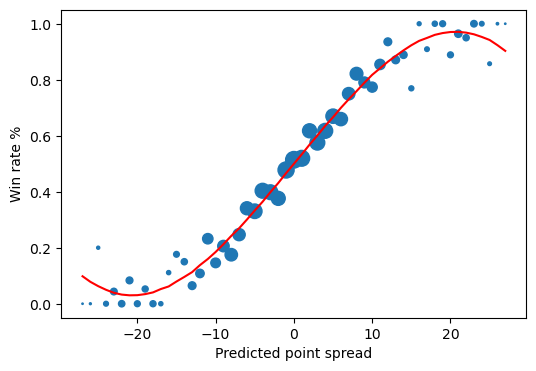

In [25]:
# win margin model predictions and win probability spline fit on the same plot
df = pd.DataFrame({'pred': np.round(oof_preds,0), 
                   'label': np.array(oof_targets)>0, 
                   'spline_fit': spline_fit})
df = df.groupby('pred')[['label', 'spline_fit']].agg(['mean', 'count']).reset_index()

fig, ax1 = plt.subplots(figsize = (6,4))
ax1.scatter(df['pred'], df['label']['mean'], df['label']['count'])
ax1.plot(df['pred'], df['spline_fit']['mean'], 'r')
ax1.set_xlabel('Predicted point spread')
ax1.set_ylabel('Win rate %')
plt.show()

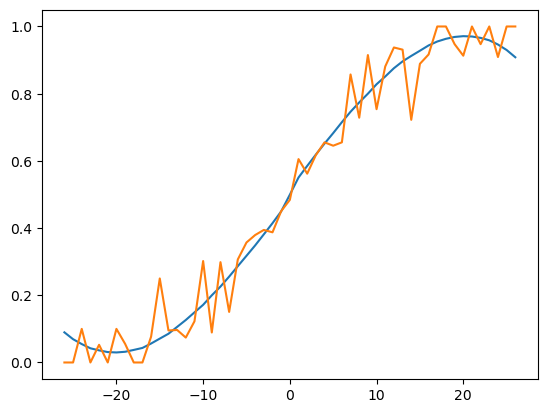

In [26]:
plot_df = pd.DataFrame({"pred": oof_preds, "label": (np.array(oof_targets) > 0).astype(int), "spline": spline_fit})

plot_df["pred_int"] = plot_df["pred"].astype(int)
plot_df = plot_df.groupby('pred_int')[['spline', 'label']].mean().reset_index()


plt.figure()
plt.plot(plot_df.pred_int,plot_df.spline)
plt.plot(plot_df.pred_int,plot_df.label)

In [27]:
# construct dataframe for submission
sample_submission = pd.concat([
    pd.read_csv(DATA_PATH + "SampleSubmissionStage2.csv"),
], ignore_index=True)

X = sample_submission.copy()
X['Season'] = X['ID'].apply(lambda t: int(t.split('_')[0]))

X['T1_TeamID'] = X['ID'].apply(lambda t: int(t.split('_')[1]))
X['T2_TeamID'] = X['ID'].apply(lambda t: int(t.split('_')[2]))

X['T1_TeamID'] = X['T1_TeamID'].astype(str)
X['T2_TeamID'] = X['T2_TeamID'].astype(str)

season_statistics_T1['T1_TeamID'] = season_statistics_T1['T1_TeamID'].astype(str)
season_statistics_T2['T2_TeamID'] = season_statistics_T2['T2_TeamID'].astype(str)

X = pd.merge(X, season_statistics_T1, on = ['Season', 'T1_TeamID'], how = 'left')
X = pd.merge(X, season_statistics_T2, on = ['Season', 'T2_TeamID'], how = 'left')

X = pd.merge(X, glm_quality_T1, on = ['Season', 'T1_TeamID'], how = 'left')
X = pd.merge(X, glm_quality_T2, on = ['Season', 'T2_TeamID'], how = 'left')

X = pd.merge(X, seeds_T1, on = ['Season', 'T1_TeamID'], how = 'left')
X = pd.merge(X, seeds_T2, on = ['Season', 'T2_TeamID'], how = 'left')

last14days_stats_T1['T1_TeamID'] = last14days_stats_T1['T1_TeamID'].astype(str)
last14days_stats_T2['T2_TeamID'] = last14days_stats_T2['T2_TeamID'].astype(str)

X = pd.merge(X, last14days_stats_T1, on = ['Season', 'T1_TeamID'], how = 'left')
X = pd.merge(X, last14days_stats_T2, on = ['Season', 'T2_TeamID'], how = 'left')

X["Seed_diff"] = X["T1_seed"] - X["T2_seed"]
X["qual_diff"] = X["T1_quality"] - X["T2_quality"]
X["qual_point_diff"] = X["T1_quality_points"] - X["T2_quality_points"]
X["O_D_diff"] = X["T1_quality_offense"] - X["T2_quality_defense"]
X["D_O_diff"] = X["T2_quality_offense"] - X["T1_quality_defense"]
X["avg_qual_point"] = (X["T1_quality_points"] + X["T2_quality_points"])/2
X["avg_qual"] = (X["T1_quality"] + X["T2_quality"])/2

In [28]:
# inference for every model, take average as final prediction
preds = []
for oof_season in set(tourney_data.Season):
    dtest = xgb.DMatrix(X[features].values)
    margin_preds = models[oof_season].predict(dtest)
    probs = np.clip(spline_model(np.clip(margin_preds, -t, t)), 0, 1)
    preds.append(probs)
X['Pred'] = np.array(preds).mean(axis=0)

X.loc[((X["T1_seed"] == 1) & (X["T2_seed"] == 16)) | ((X["T1_seed"] == 2) & (X["T2_seed"] == 15)), 'Pred'] = 1
X.loc[((X["T1_seed"] == 16) & (X["T2_seed"] == 1)) | ((X["T1_seed"] == 15) & (X["T2_seed"] == 2)), 'Pred'] = 0

In [29]:
#GAMBLE HERE
# X["T1_TeamID"] = X["T1_TeamID"].astype(int)
# X["T2_TeamID"] = X["T2_TeamID"].astype(int)

# X.loc[X["T1_TeamID"] == 1181, 'Pred'] = 1
# X.loc[X["T2_TeamID"] == 1181, 'Pred'] = 0


<Axes: xlabel='Pred', ylabel='Count'>

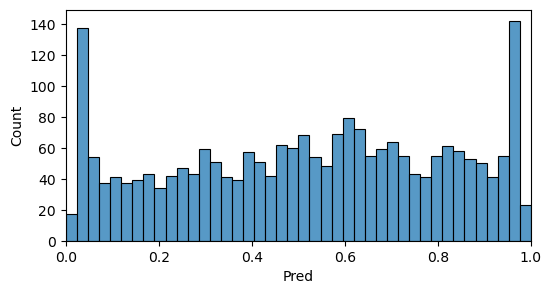

In [30]:
# sanity check to check for win probability distribution
m = X.loc[(~pd.isnull(X.T1_seed)) & (~pd.isnull(X.T2_seed))]
plt.figure(figsize=(6, 3))
plt.xlim(0, 1)
sns.histplot(m['Pred'], bins=42)

In [31]:
pd.pivot_table(data = X, index='T1_seed', columns='T2_seed', values='Pred', aggfunc='mean').style.bar(color='#5fba7d', vmin=0, vmax=1)

T2_seed,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000,10.000000,11.000000,12.000000,13.000000,14.000000,15.000000,16.000000
T1_seed,,,,,,,,,,,,,,,,
1.000000,0.476082,0.746329,0.784282,0.842187,0.865079,0.845558,0.822596,0.814820,0.889852,0.887761,0.873312,0.914648,0.950156,0.962011,0.964697,1.000000
2.000000,0.241474,0.464685,0.521094,0.655593,0.673253,0.659840,0.631508,0.619646,0.700656,0.723186,0.682283,0.729521,0.856354,0.880720,1.000000,0.966849
3.000000,nan,0.435516,0.486798,0.552841,0.622056,0.617295,0.563598,0.542521,0.683860,0.696041,0.647311,0.731135,0.832824,0.879071,0.932647,0.966920
4.000000,0.197596,0.411568,0.405115,0.589420,0.617813,0.603103,0.534337,0.541505,0.631475,0.637326,0.603037,0.687154,0.796818,0.840317,0.924478,0.967224
5.000000,0.190289,0.337430,0.363934,0.492102,0.514840,0.513617,0.463537,0.476821,0.602387,0.582956,0.539657,0.628182,0.769637,0.830103,0.895091,0.963967
6.000000,0.202678,0.369398,0.401740,0.520771,0.578823,0.578226,0.502277,0.515514,0.642479,0.631196,0.581138,0.692478,0.778875,0.848741,0.904442,0.965583
7.000000,nan,0.389770,0.415900,0.537510,0.606893,0.609287,0.520832,0.538664,0.671166,0.642364,0.598354,0.672635,0.798826,0.856711,0.916707,0.963056
8.000000,0.240023,0.426162,0.456861,0.561169,0.624497,0.611863,0.543019,0.576082,0.684228,0.677429,0.629464,0.732238,0.814300,0.878669,0.932014,0.964606
9.000000,0.148639,0.320131,0.358742,0.456984,0.522319,0.486564,0.431328,0.430069,0.620333,0.576523,0.525261,0.636809,0.736946,0.806227,0.880750,0.963747


In [ ]:
final_submission = X[['ID', 'Pred']]

final_submission[['ID','Pred']].to_csv("../submissions/Final_submission_no_gamble.csv", index = None)